# Отток клиентов



Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 



Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

# 1. Подготовка данных

In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
import warnings
warnings.filterwarnings("ignore")
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

In [56]:
churn = pd.read_csv('/datasets/Churn.csv')
churn.head(10)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0
5,6,15574012,Chu,645,Spain,Male,44,8.0,113755.78,2,1,0,149756.71,1
6,7,15592531,Bartlett,822,France,Male,50,7.0,0.00,2,1,1,10062.80,0
7,8,15656148,Obinna,376,Germany,Female,29,4.0,115046.74,4,1,0,119346.88,1
8,9,15792365,He,501,France,Male,44,4.0,142051.07,2,0,1,74940.50,0
9,10,15592389,H?,684,France,Male,27,2.0,134603.88,1,1,1,71725.73,0


In [57]:
churn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
RowNumber          10000 non-null int64
CustomerId         10000 non-null int64
Surname            10000 non-null object
CreditScore        10000 non-null int64
Geography          10000 non-null object
Gender             10000 non-null object
Age                10000 non-null int64
Tenure             9091 non-null float64
Balance            10000 non-null float64
NumOfProducts      10000 non-null int64
HasCrCard          10000 non-null int64
IsActiveMember     10000 non-null int64
EstimatedSalary    10000 non-null float64
Exited             10000 non-null int64
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


Данные как мне кажется пришли ко мне в хорошей обработке, пропуски есть в 1 столбе.

На первый взгляд в таблице есть 3 дублирующихся столбца, - номер строки, имя и id клиента. в будущем я оставлю только 1.

In [58]:
churn.duplicated().sum()

0

In [59]:
churn.isnull().sum()
churn = churn.fillna(0)

In [60]:
churn.isnull().sum()

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

In [61]:
churn['Tenure'] = churn['Tenure'].astype('int')

In [62]:
churn['Balance'] = churn['Balance'].round()
churn['Balance'] = churn['Balance'].astype('int')
churn['EstimatedSalary'] = churn['EstimatedSalary'].round()
churn['EstimatedSalary'] = churn['EstimatedSalary'].astype('int')

Дубликатов я не обнаружил, пропуски в столбце с недвижимостью я заменил на 0, тк скорее всего люди без недвижимости ее просто не указали.

Так же я округлил столбцы - баланс и доход и привел все float к int

In [63]:
churn.head(10)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0,1,1,1,101349,1
1,2,15647311,Hill,608,Spain,Female,41,1,83808,1,0,1,112543,0
2,3,15619304,Onio,502,France,Female,42,8,159661,3,1,0,113932,1
3,4,15701354,Boni,699,France,Female,39,1,0,2,0,0,93827,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125511,1,1,1,79084,0
5,6,15574012,Chu,645,Spain,Male,44,8,113756,2,1,0,149757,1
6,7,15592531,Bartlett,822,France,Male,50,7,0,2,1,1,10063,0
7,8,15656148,Obinna,376,Germany,Female,29,4,115047,4,1,0,119347,1
8,9,15792365,He,501,France,Male,44,4,142051,2,0,1,74940,0
9,10,15592389,H?,684,France,Male,27,2,134604,1,1,1,71726,0


In [64]:
target_0 = churn[churn['Exited'] == 0]['Exited'].count()
target_1 = churn[churn['Exited']== 1]['Exited'].count()
print(target_0,target_1)

7963 2037


No handles with labels found to put in legend.


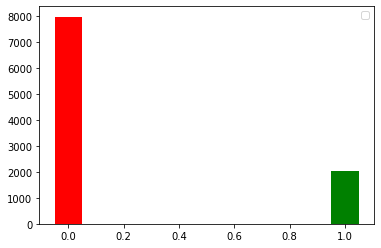

In [65]:
%matplotlib inline
labels = [0,1]
plt.bar(labels[0],target_0, width=0.1,color = 'red')
plt.bar(labels[1],target_1,width=0.1,color = 'green')
plt.legend()

Я посчитал и построил график клиентов которые перестали быть клиентами банка (зеленые) и нет (красные). В будущем мне эти цифры пригодятся при увеличении и уменьшении выборки

In [66]:
churn = churn.drop(['Surname', 'CustomerId'], axis = 1)
churn_ohe = pd.get_dummies(churn, drop_first=True)
churn_ohe.head(10)

,RowNumber,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
0,1,619,42,2,0,1,1,1,101349,1,0,0,0
1,2,608,41,1,83808,1,0,1,112543,0,0,1,0
2,3,502,42,8,159661,3,1,0,113932,1,0,0,0
3,4,699,39,1,0,2,0,0,93827,0,0,0,0
4,5,850,43,2,125511,1,1,1,79084,0,0,1,0
5,6,645,44,8,113756,2,1,0,149757,1,0,1,1
6,7,822,50,7,0,2,1,1,10063,0,0,0,1
7,8,376,29,4,115047,4,1,0,119347,1,1,0,0
8,9,501,44,4,142051,2,0,1,74940,0,0,0,1
9,10,684,27,2,134604,1,1,1,71726,0,0,0,1


используя One-Hot Encoding я перекодировал таблицу что бы избавится от не численных переменных. при этом я удалил первый столбец для не попадания в дамми ловушку

In [67]:
target = churn_ohe['Exited']
features = churn_ohe.drop(['Exited'], axis = 1)

Назначил целевой признак и фитчи

In [68]:
features_train_0, features_valid, target_train_0, target_valid = train_test_split(
    features, target, test_size = 0.13, random_state = 12345)
features_train, features_test, target_train, target_test = train_test_split(features_train_0, target_train_0, test_size = 0.15, random_state = 12345)


In [69]:
print('Обучающие признаки', features_train.shape)
print('валидационные признаки', features_valid.shape)
print('Тестовые признаки', features_test.shape)




Обучающие признаки (7395, 12)
валидационные признаки (1300, 12)
Тестовые признаки (1305, 12)


разбил выборку на тренировочную (74%) и валидационную и тестовую по (13%)

In [70]:
numeric = ['CreditScore', 'Age', 'Tenure', 'Balance', 'EstimatedSalary']
scaler = StandardScaler()
scaler.fit(features_train[numeric])
features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])


использую standartscaler я маштабировал численные признаки

# 2. Исследование задачи

#### дерево решений

In [71]:
model = DecisionTreeClassifier()
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)
print('Accuracy сырых данных:', accuracy_score(target_valid, predicted_valid))

Accuracy сырых данных: 0.7953846153846154


In [72]:
target_pred_constant = pd.Series(0, index=target_valid.index)
print(accuracy_score(target_valid, target_pred_constant))

0.7876923076923077


In [73]:
print(confusion_matrix(target_valid, predicted_valid))

[[905 119]
 [147 129]]


In [74]:
print(recall_score(target_valid, predicted_valid))

0.4673913043478261


In [75]:
print(precision_score(target_valid, predicted_valid))

0.5201612903225806


In [76]:
print(f1_score(target_valid, predicted_valid))

0.4923664122137405


#### случайный лес

In [77]:
model1 = RandomForestClassifier()
model1.fit(features_train, target_train)
predicted_valid1 = model1.predict(features_valid)
print('Accuracy сырых данных леса:', accuracy_score(target_valid, predicted_valid1))

Accuracy сырых данных леса: 0.8446153846153847


In [78]:
print(confusion_matrix(target_valid, predicted_valid1))

[[992  32]
 [170 106]]


In [79]:
print(recall_score(target_valid, predicted_valid1))

0.38405797101449274


In [80]:
print(precision_score(target_valid, predicted_valid1))

0.7681159420289855


In [81]:
print(f1_score(target_valid, predicted_valid1))

0.5120772946859903


#### логистическая регрессия

In [82]:
model2 = LogisticRegression()
model2.fit(features_train, target_train)
predicted_valid2 = model2.predict(features_valid)
print('Accuracy сырых данных регрессии:', accuracy_score(target_valid, predicted_valid2))

Accuracy сырых данных регрессии: 0.8061538461538461


In [83]:
print(confusion_matrix(target_valid, predicted_valid2))

[[997  27]
 [225  51]]


In [84]:
print(recall_score(target_valid, predicted_valid2))

0.18478260869565216


In [85]:
print(precision_score(target_valid, predicted_valid2))

0.6538461538461539


In [86]:
print(f1_score(target_valid, predicted_valid2))

0.28813559322033894


Я проверил 3 модели на сырых данных, дерево решений показало средний результат примерно 0.5 по каждой метрике. Случайный лес показал хороший результат по точности и немного заниженную полноту.

Логистическая же регрессия по полносте полностью "просела" всего 0.18


Исходя из этих данных я уже могу понимать что лучшей моделью будет случайный лес, нужно будет только поднять полноту.

# 3. Борьба с дисбалансом

Для борьбы с дисбалансом исходя из данных выше (отрицательных таргетов примерно 8000 положительных 2000) я увеличу положительную выборку на 2 а отрицательную уменьшу так же на 2, получится соотношение примерно 1:1

проверять результат я буду на модели случайного леса, которая показала лучший результат на сырых данных.

In [87]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

features_upsampled, target_upsampled = upsample(features_train, target_train, 2)



In [88]:
model = RandomForestClassifier()
model.fit(features_upsampled, target_upsampled)
predicted_valid = model.predict(features_valid)

print("F1:", f1_score(target_valid, predicted_valid))

F1: 0.5248868778280543


In [89]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])   
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345)
    
    return features_downsampled, target_downsampled

features_downsampled, target_downsampled = downsample(features_upsampled, target_upsampled, 0.5)


In [90]:
model = RandomForestClassifier()
model.fit(features_downsampled, target_downsampled)
predicted_valid = model.predict(features_valid)

print("F1:", f1_score(target_valid, predicted_valid))

F1: 0.5918003565062389


удалось увеличить f1 метрику, но не сильно. посмотрим, может быть при настройке гиперпараметров получится выше.

# 4. Тестирование модели

Проверю 3 модели на тренировочных данных которые я получил при увеличении и уменьшении выборки

сначала проверю на валидацонной выборке, после чего на тестевой с лучшими гиперпаратметрами 

In [91]:
for i in range(1,16):    
    model_tree = DecisionTreeClassifier(random_state = 112325, max_depth = i)
    model_tree.fit(features_downsampled, target_downsampled)
    predictions_tree = model_tree.predict(features_valid)
    f1_tree = f1_score(predictions_tree, target_valid)
    print('F1 при max_depth :', i, '-', f1_tree)

F1 при max_depth : 1 - 0.5071633237822349
F1 при max_depth : 2 - 0.5376044568245125
F1 при max_depth : 3 - 0.5376044568245125
F1 при max_depth : 4 - 0.5941558441558441
F1 при max_depth : 5 - 0.604724409448819
F1 при max_depth : 6 - 0.6058732612055642
F1 при max_depth : 7 - 0.5825242718446602
F1 при max_depth : 8 - 0.5615615615615617
F1 при max_depth : 9 - 0.5566714490674318
F1 при max_depth : 10 - 0.5372262773722628
F1 при max_depth : 11 - 0.5348101265822786
F1 при max_depth : 12 - 0.5358255451713396
F1 при max_depth : 13 - 0.541795665634675
F1 при max_depth : 14 - 0.540453074433657
F1 при max_depth : 15 - 0.5206349206349206


In [92]:
for i in range(10, 51, 5):
    for j in range(1, 20):
        model_forest = RandomForestClassifier(n_estimators = i, max_depth = j, random_state = 12345)
        model_forest.fit(features_downsampled, target_downsampled)
        predictions_forest = model_forest.predict(features_valid)
        f1_forest = f1_score(predictions_forest, target_valid)
        print('F1 при n_estimators :', i, 'и при max_depth=', j, '-', f1_forest)

F1 при n_estimators : 10 и при max_depth= 1 - 0.551048951048951
F1 при n_estimators : 10 и при max_depth= 2 - 0.5579514824797843
F1 при n_estimators : 10 и при max_depth= 3 - 0.593939393939394
F1 при n_estimators : 10 и при max_depth= 4 - 0.622432859399684
F1 при n_estimators : 10 и при max_depth= 5 - 0.6180665610142632
F1 при n_estimators : 10 и при max_depth= 6 - 0.6182380216383307
F1 при n_estimators : 10 и при max_depth= 7 - 0.6042944785276073
F1 при n_estimators : 10 и при max_depth= 8 - 0.5938461538461538
F1 при n_estimators : 10 и при max_depth= 9 - 0.6102719033232629
F1 при n_estimators : 10 и при max_depth= 10 - 0.6280487804878049
F1 при n_estimators : 10 и при max_depth= 11 - 0.6283048211508554
F1 при n_estimators : 10 и при max_depth= 12 - 0.5857605177993528
F1 при n_estimators : 10 и при max_depth= 13 - 0.6022187004754357
F1 при n_estimators : 10 и при max_depth= 14 - 0.5756097560975609
F1 при n_estimators : 10 и при max_depth= 15 - 0.5987261146496815
F1 при n_estimators : 

In [93]:
model_regression = LogisticRegression(random_state=12345)
model_regression.fit(features_downsampled, target_downsampled)
predictions_regression = model_regression.predict(features_valid)
f1_regression = f1_score(predictions_tree, target_valid)
print('f1 ЛР =', f1_regression)

f1 ЛР = 0.5206349206349206


## Проверка каждой модели с лучшими гиперпараметрами на тестовых данных.


Проверка с разными гиперпараметрами показала что для леса оптималььное количество деревьев - 45 и глубина 7, в дереве же лучший результат был при глубине 5

проверим эти данные на тестевых данных:

In [94]:
model_forest_test = RandomForestClassifier(n_estimators = 45, max_depth = 9, random_state = 12345)
model_forest_test.fit(features_downsampled, target_downsampled)
predictions_forest_test = model_forest_test.predict(features_test)
f1_forest_test = f1_score(predictions_forest_test, target_test)
print('f1 леса на тестовой выборке =', f1_forest_test)

f1 леса на тестовой выборке = 0.6344605475040258


In [95]:
model_tree_test = DecisionTreeClassifier(random_state = 112325,  max_depth = 5)
model_tree_test.fit(features_downsampled, target_downsampled)
predictions_tree_test = model_tree_test.predict(features_test)
f1_tree_test = f1_score(predictions_tree_test, target_test)
print('f1 дерева на тестовой выборке =', f1_tree_test)

f1 дерева на тестовой выборке = 0.5895061728395061


In [96]:
model_regression_test = LogisticRegression(random_state=12345)
model_regression_test.fit(features_downsampled, target_downsampled)
predictions_regression_test = model_regression_test.predict(features_test)
f1_regression_test = f1_score(predictions_regression_test, target_test)
print('f1 логистической регрессии на тестевой выборке =', f1_regression_test)

f1 логистической регрессии на тестевой выборке = 0.5197889182058048


## Вывод

из 3 моделей на тестевых данных лучший результат показывает "случайный лес".



## auc roc

Для понимания, являются ли предсказания моей лучшей модели случайными или нет, я подсчитаю auc_roc и построю его график

In [97]:
model_forest_test1 = RandomForestClassifier(n_estimators = 45, max_depth = 9, random_state = 12345)
model_forest_test1.fit(features_downsampled, target_downsampled)


probabilities_test = model_forest_test1.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]

auc_roc = roc_auc_score(target_test, probabilities_one_test)
print('auc_roc =', auc_roc)

auc_roc = 0.8595569540237958


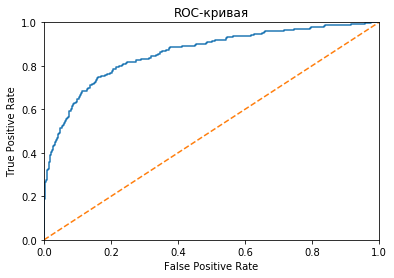

In [98]:
probabilities_test = model_forest_test1.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]
fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test)

plt.figure()

plt.plot(fpr, tpr)


plt.plot([0, 1], [0, 1], linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')

plt.show()

## Выводы


Мне удалось добиться F1 score выше 0.59 (0.63) используя увеличение и уменьшенеие выборок и подбирая различные гиперпараметры.

График и значения auc roc (0.86) показывают что предсказания модели на случайны.